# Prediciendo la diabetes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import math
import numpy as np
import seaborn as sns
from sklearn import tree
import missingno as msno
from itertools import product
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import f_classif, SelectKBest, RFE

In [2]:
# Cargamos el data set
ruta = r"C:\Users\Alia\Documents\GitHub\Arbol de decisiones\aliasys-arbol-de-decision\data\raw\diabetes.csv"
df = pd.read_csv(ruta)

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## Procedemos a realizar el EDA

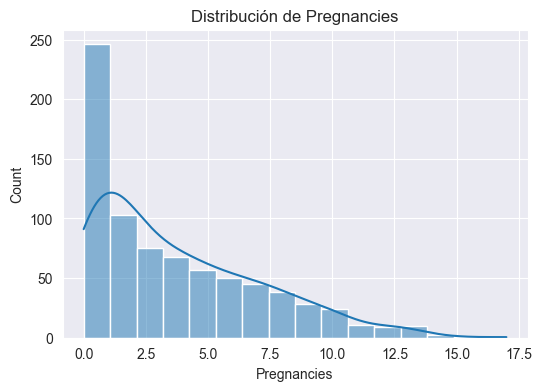

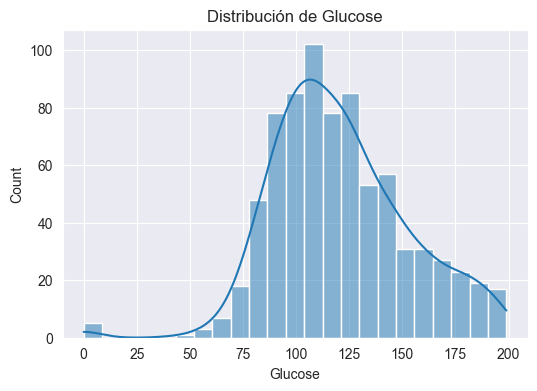

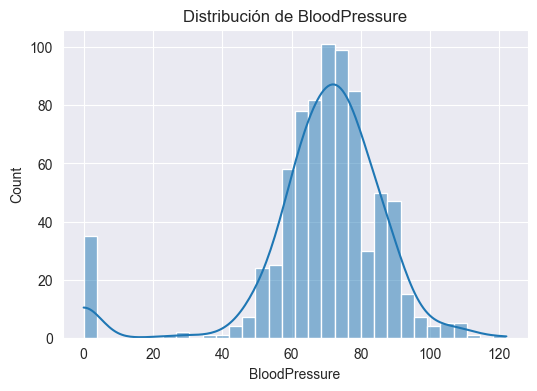

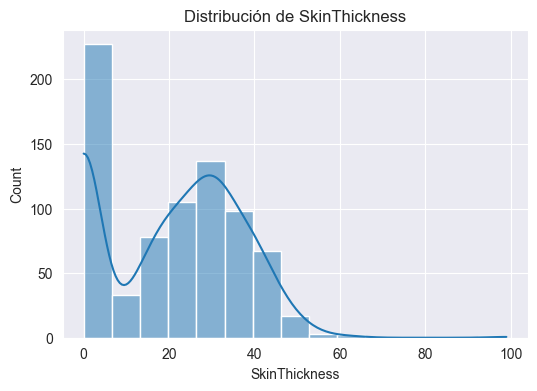

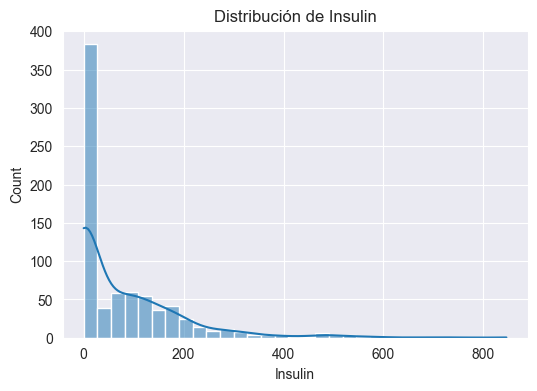

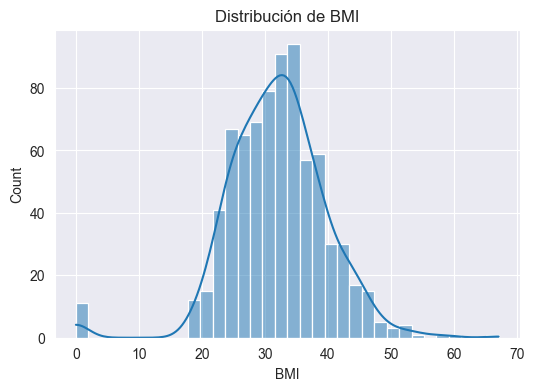

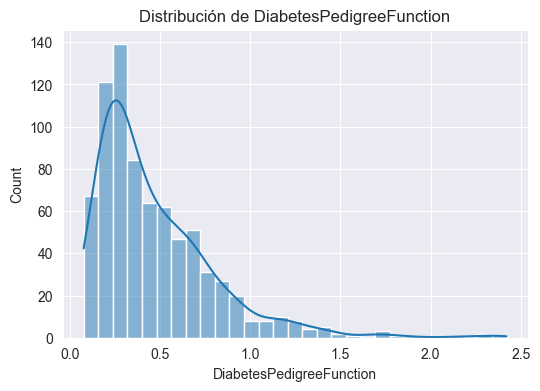

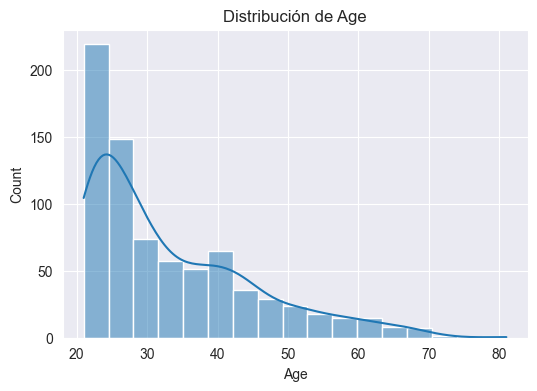

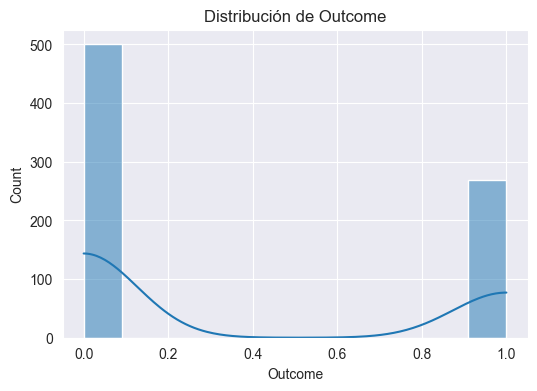

In [6]:
# Analizar las variables numéricas
numerical = df.select_dtypes(include=np.number).columns
for col in numerical:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.show()

### Observamos:
- En este dataset, hay varias variables en las que aparecen valores **iguales a 0**, lo cual **no es fisiológicamente posible** y debe interpretarse como **valores faltantes**. Como:

- `Glucose`: una glucosa en sangre de 0 no es compatible con la vida.
- `BloodPressure`: una presión arterial diastólica de 0 es inviable.
- `BMI`: un índice de masa corporal de 0 implica peso o talla nula, lo cual no es real.
- `SkinThickness`: una persona no puede tener un pliegue cutaneo 0 seria irreal.
- `Insulin`: La insulina no puede ser valor a 0, no puedes tner 0 de insulina en sangre.

- Estos ceros indican que **el valor no fue medido o registrado** en ese momento. Por lo tanto, debemos tratarlos como **valores ausentes (NaN)** antes de entrenar modelos o realizar estadísticas serias.



In [7]:
cols_con_ceros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in cols_con_ceros:
    n_zeros = (df[col] == 0).sum()

In [8]:
df[cols_con_ceros] = df[cols_con_ceros].replace(0, np.nan)

In [9]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

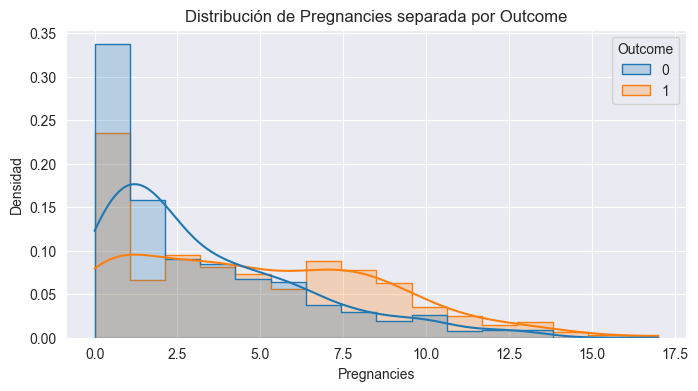

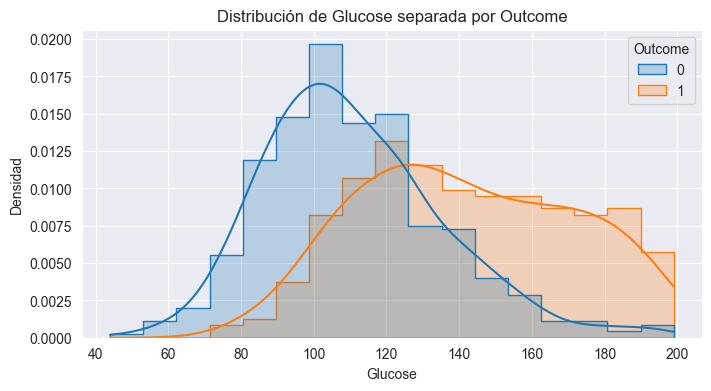

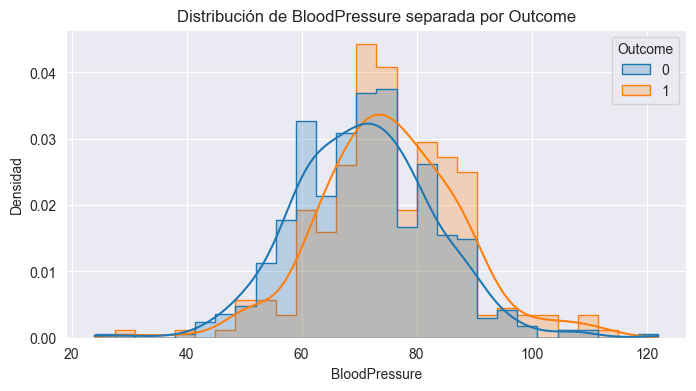

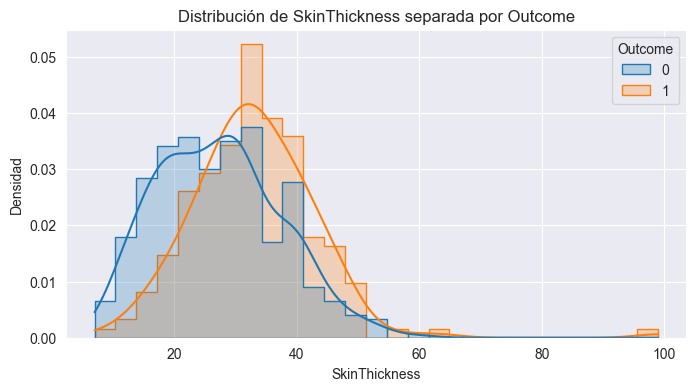

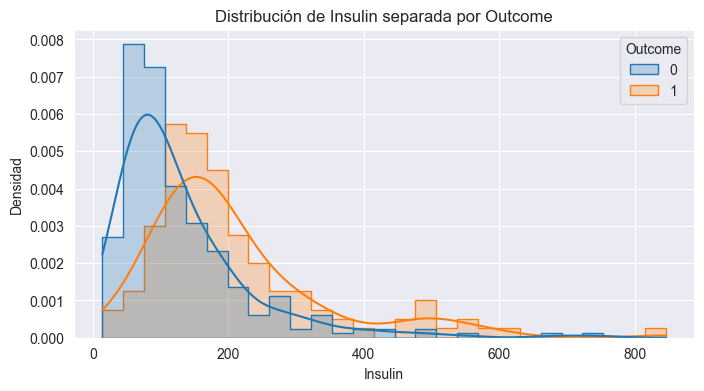

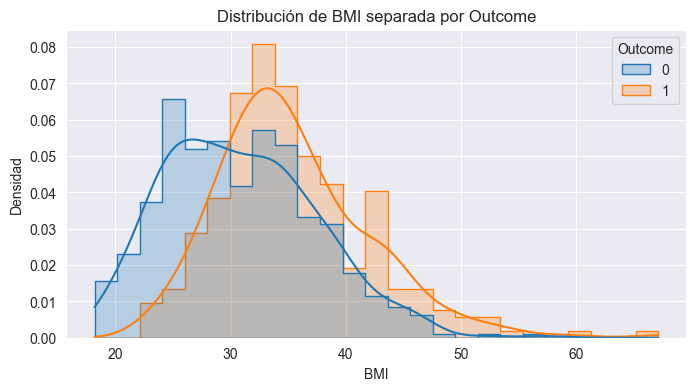

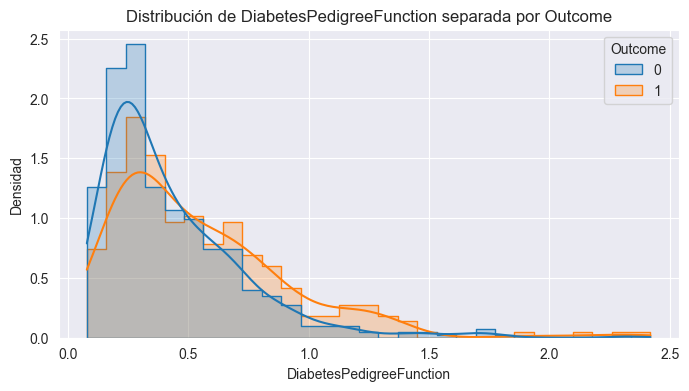

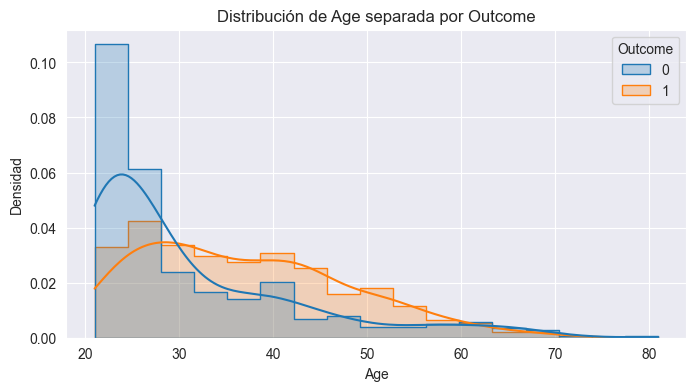

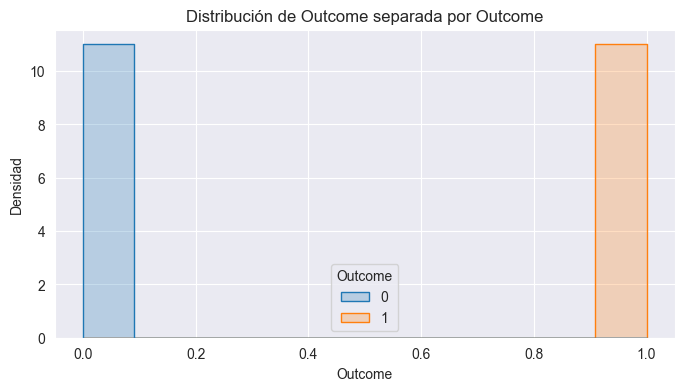

In [10]:
for col in numerical:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=col, hue='Outcome', kde=True, element='step', stat='density', common_norm=False)
    plt.title(f'Distribución de {col} separada por Outcome')
    plt.xlabel(col)
    plt.ylabel('Densidad')
    plt.show()

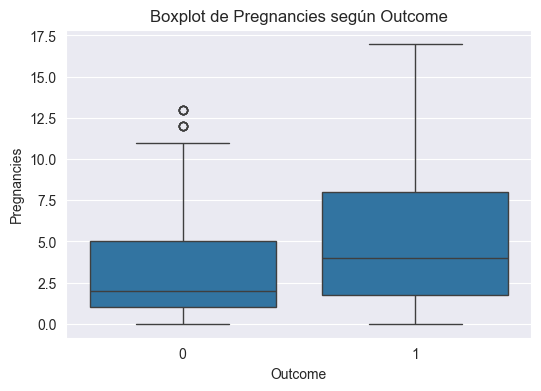

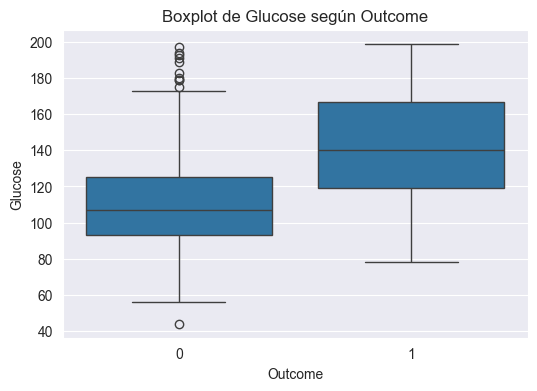

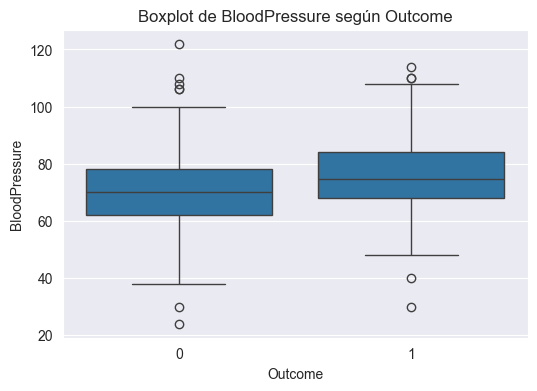

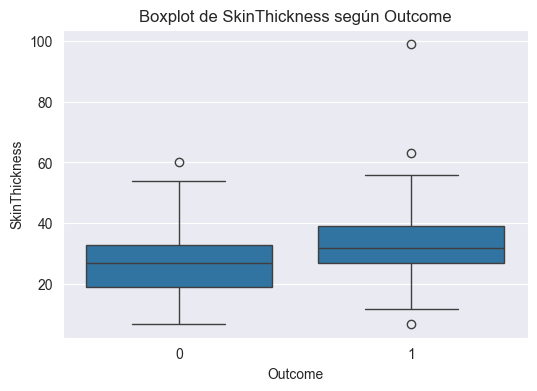

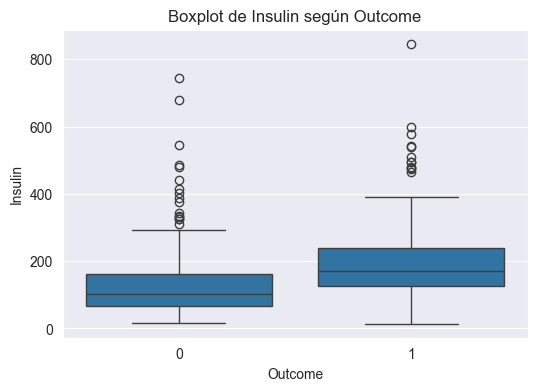

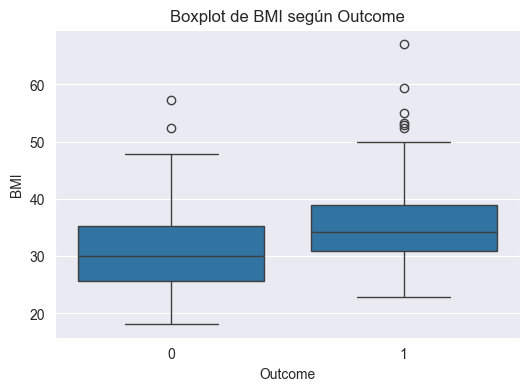

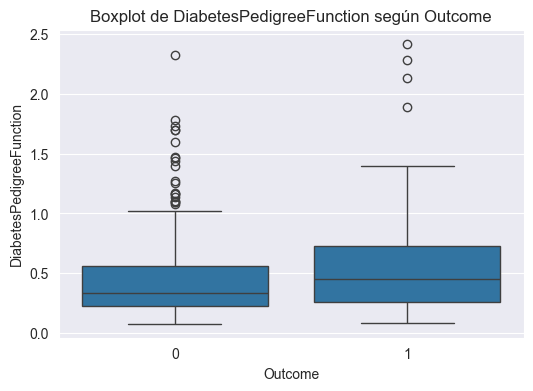

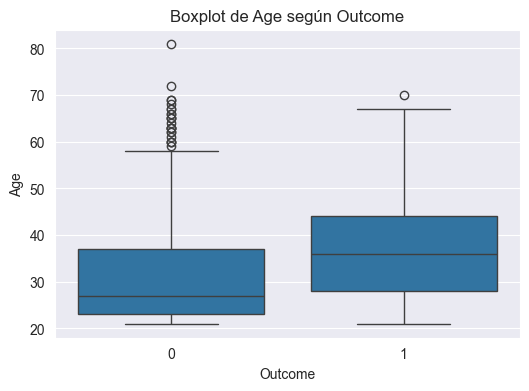

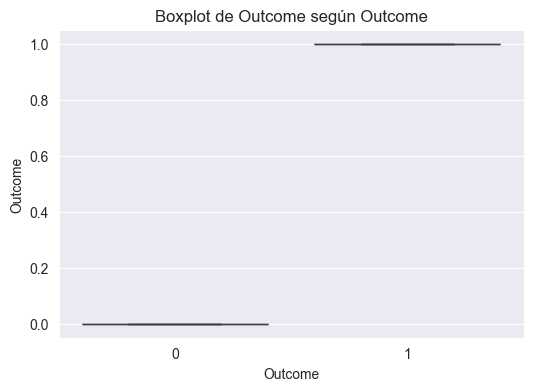

In [11]:
for col in numerical:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Outcome', y=col, data=df)
    plt.title(f'Boxplot de {col} según Outcome')
    plt.show()

## Observaciones:
> - Despuses de analizar las variables de la grafica nos damos cuenta de que 'Outcome' es la variable obbjetivo/predictora, pues ella es la que nos comenta si la persona tiene o no tiene diabetes.
> - 'Outcome' facilita interpretar qué variables afectan más la probabilidad de diabetes.
> - Los médicos y especialistas pueden usar estas conclusiones para prevención, diagnóstico y tratamiento.
> -
## Conclusión
> - **Outcome es el corazón del proyecto**, ya que define qué queremos predecir, guía el análisis y permite validar la efectividad de nuestras técnicas de modelado y visualización.

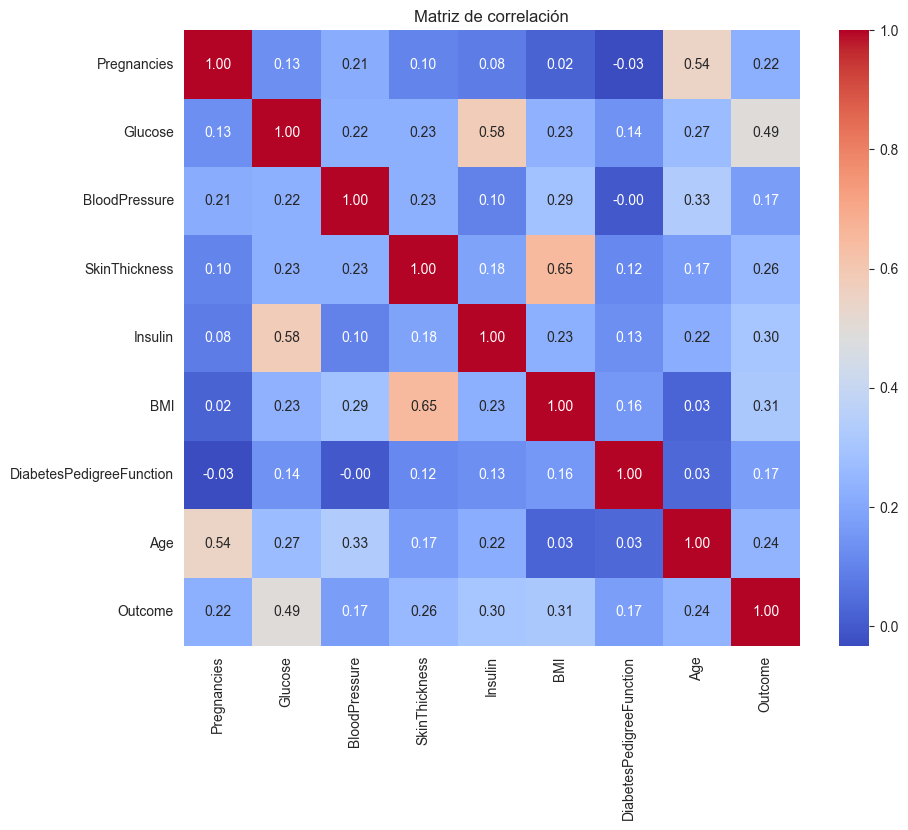

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Matriz de correlación')
plt.show()

# Correlaciones fuertes/moderadas con Outcome

- **Glucose (0.49)**: Es la variable con mayor correlación positiva con Outcome. Esto indica que niveles más altos de glucosa en sangre están fuertemente asociados con la presencia de diabetes. Es, sin duda, una variable clave para predecir el diagnóstico.

- **BMI (0.31)**: El índice de masa corporal también tiene una correlación positiva significativa. Personas con mayor BMI tienen mayor probabilidad de tener diabetes, lo que coincide con factores de riesgo conocidos.

- **Insulin (0.30)** y **SkinThickness (0.26)**: Estas variables relacionadas con la insulina y grasa subcutánea también muestran una correlación positiva moderada. Su aumento suele estar vinculado con diabetes, aunque con menor fuerza que Glucose y BMI.

## Correlaciones moderadas/bajas con Outcome

- **Age (0.24)**: La edad presenta una correlación positiva moderada, sugiriendo que el riesgo de diabetes aumenta con la edad, aunque la relación no es tan fuerte como con otras variables.

- **Pregnancies (0.22)**: El número de embarazos tiene también una correlación positiva baja-moderada, lo cual puede estar relacionado con factores hormonales y predisposición.

- **DiabetesPedigreeFunction (0.17)** y **BloodPressure (0.17)**: Aunque más bajas, estas correlaciones positivas indican cierta relación con el riesgo de diabetes.
### Conclusion:
- Podemos seleccionar **Glucose, BMI, Insulin, SkinThickness y Age** como variables clave.

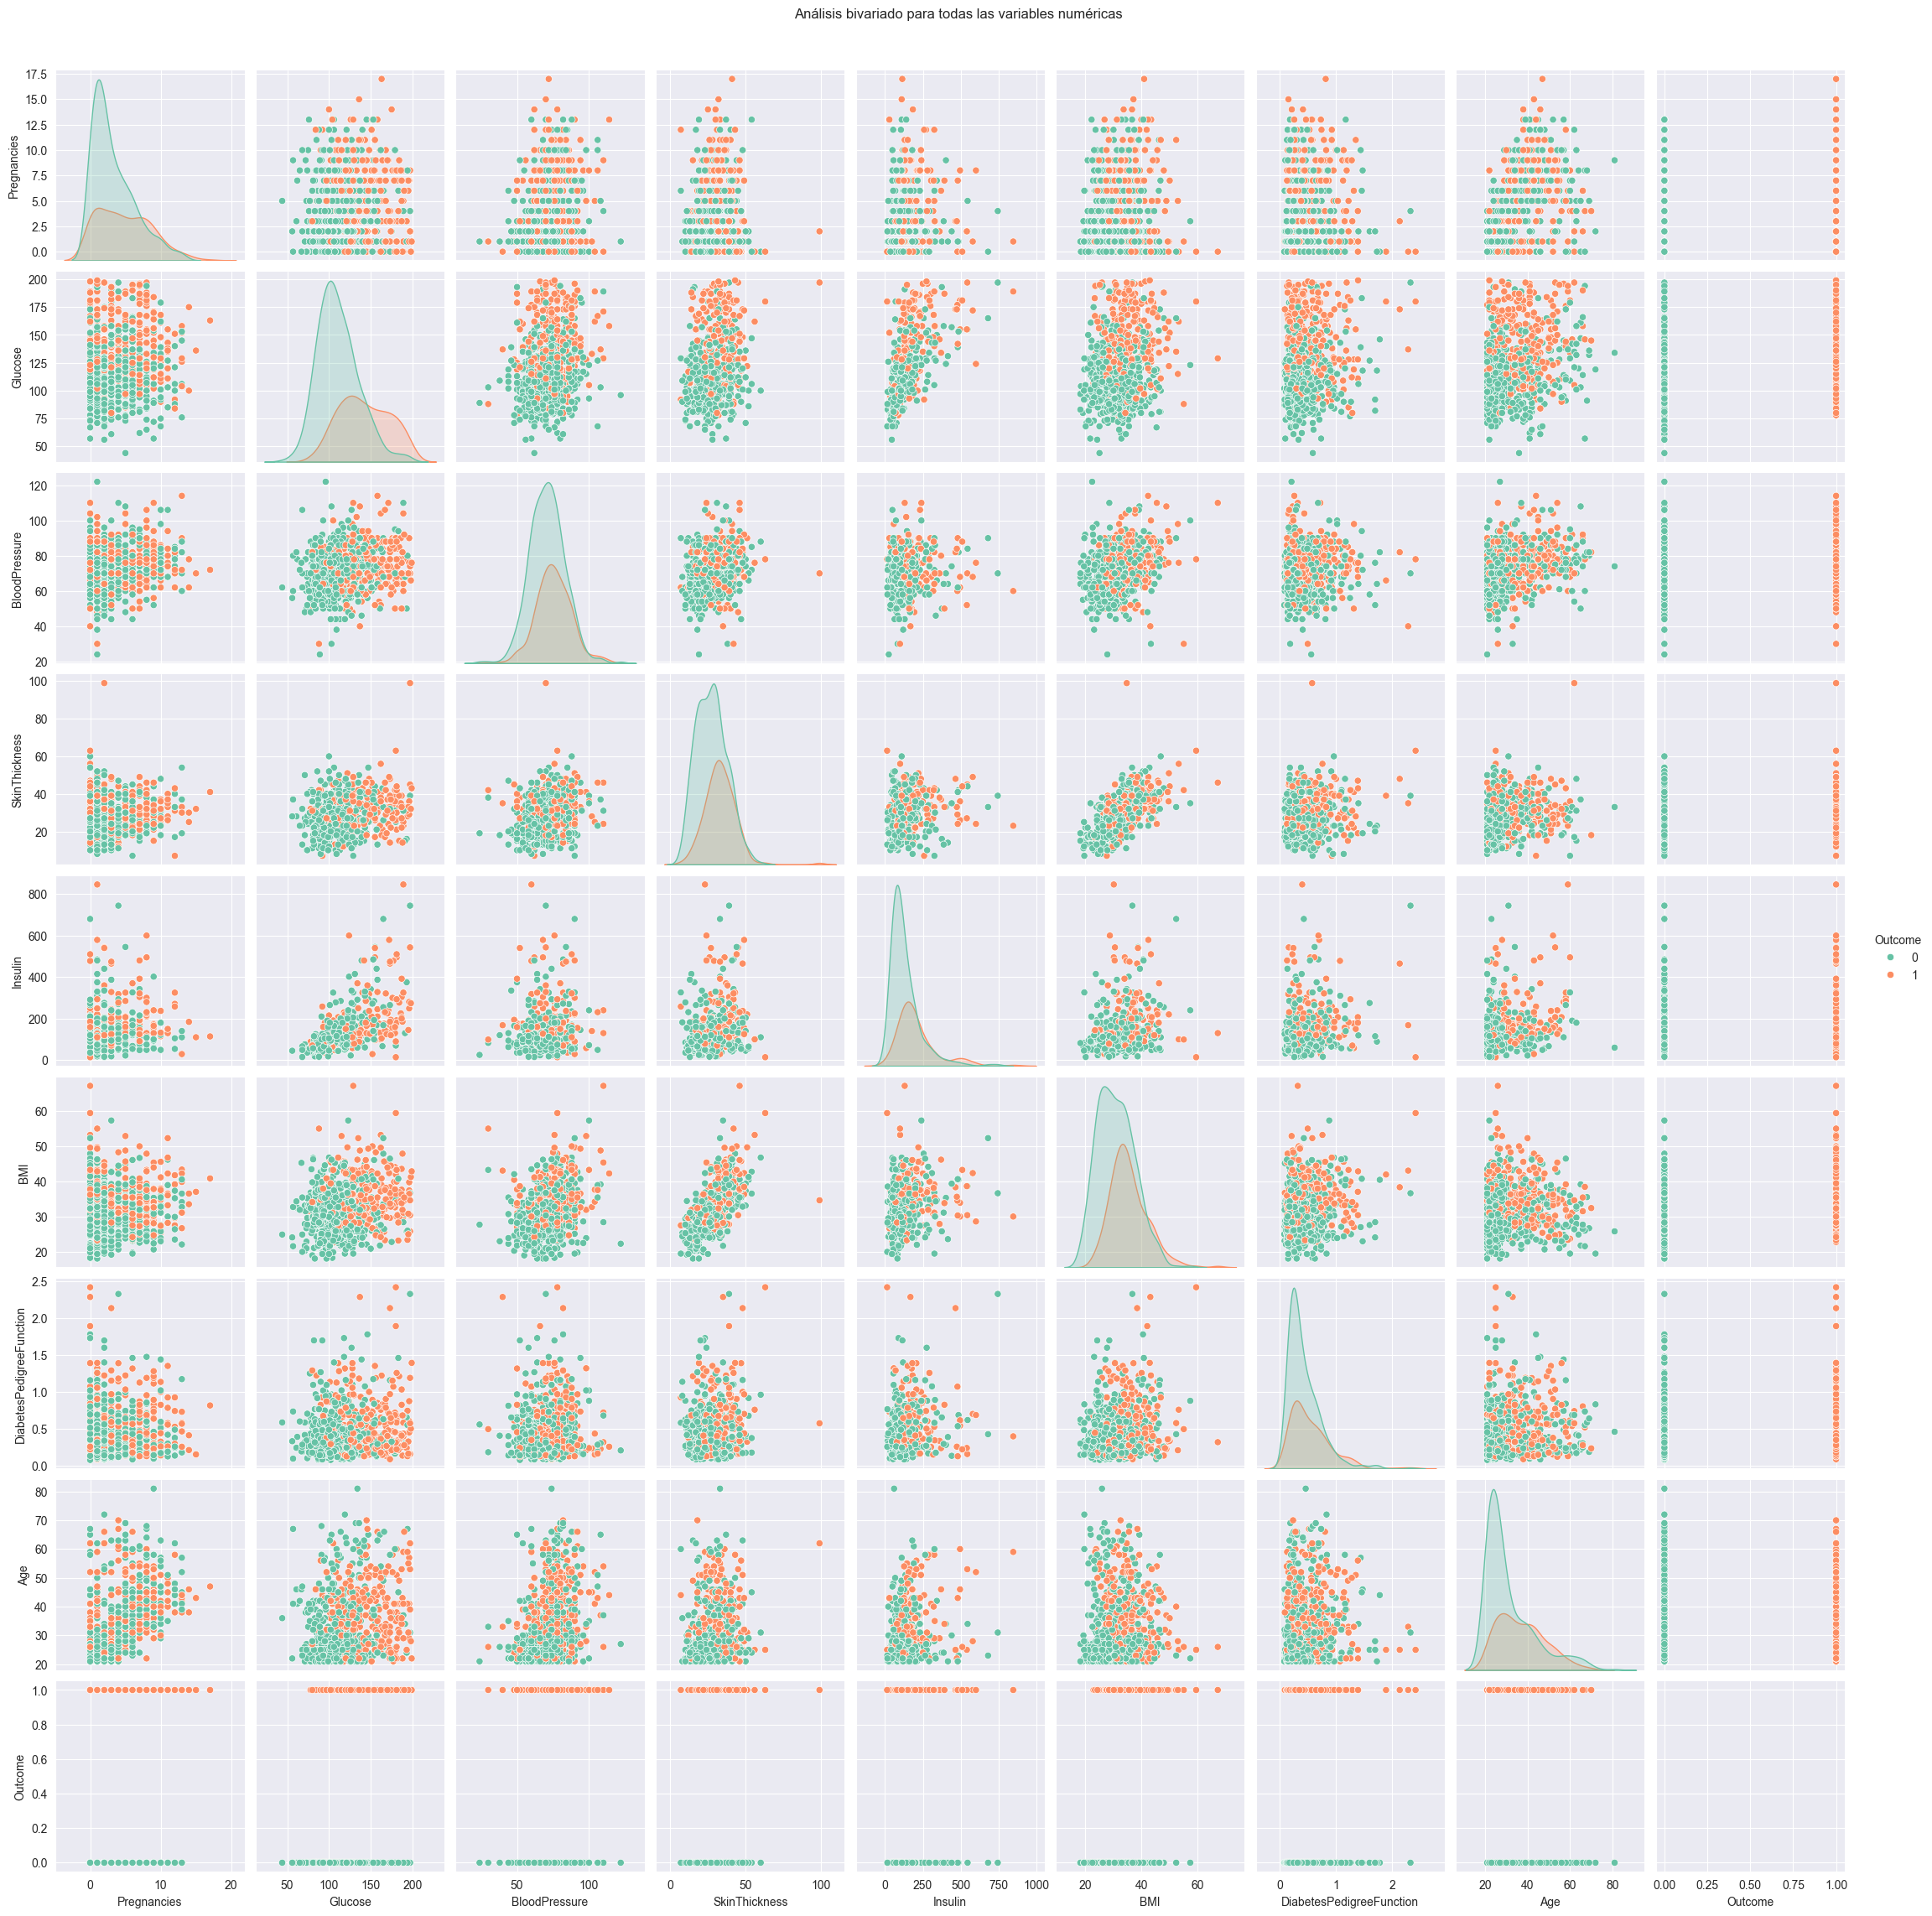

In [13]:
# Pairplot con todas las variables numéricas y hue en Outcome
sns.pairplot(df, vars=numerical, hue='Outcome', diag_kind='kde', palette='Set2')
plt.suptitle('Análisis bivariado para todas las variables numéricas', y=1.02)
plt.show()

### Pasamos al analisis de Outliers

In [16]:
df. describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


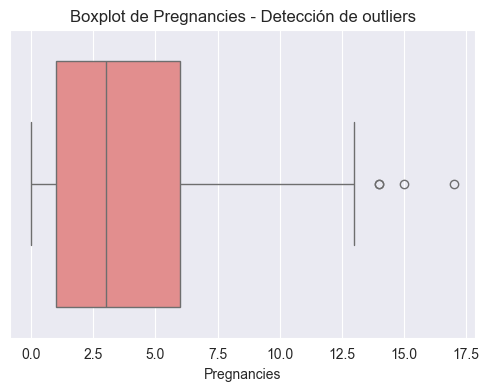

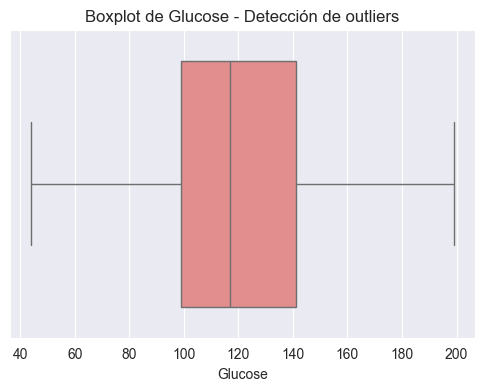

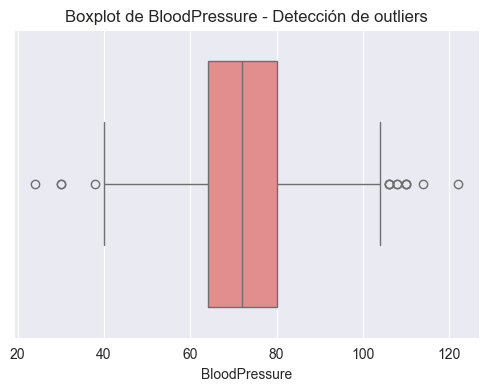

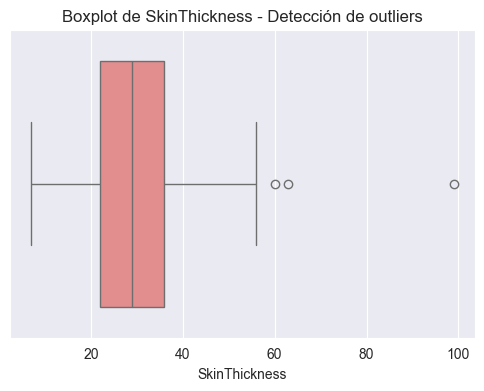

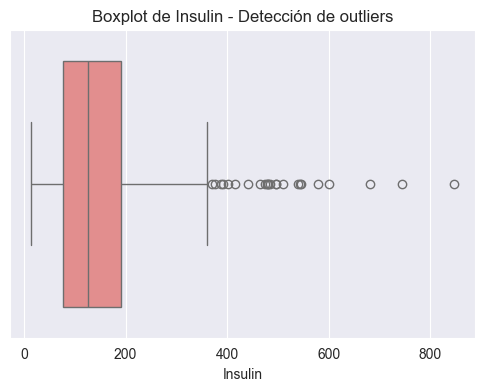

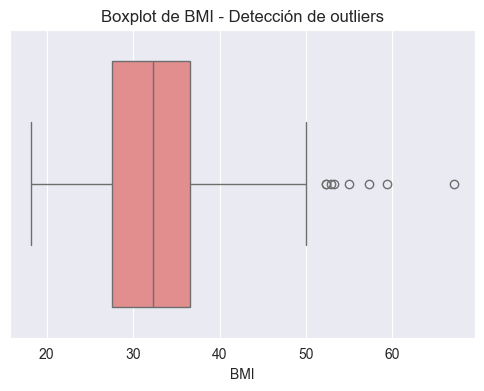

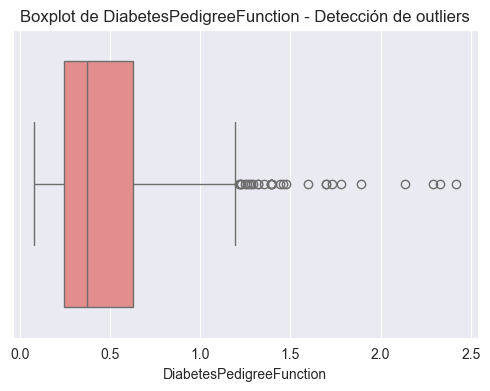

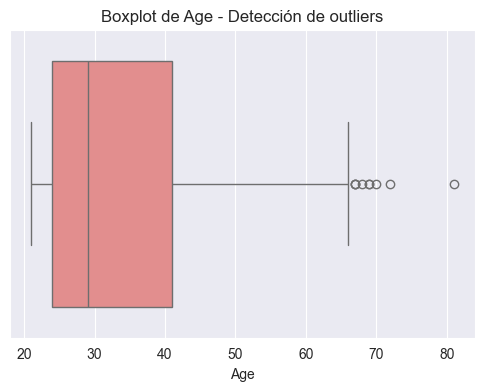

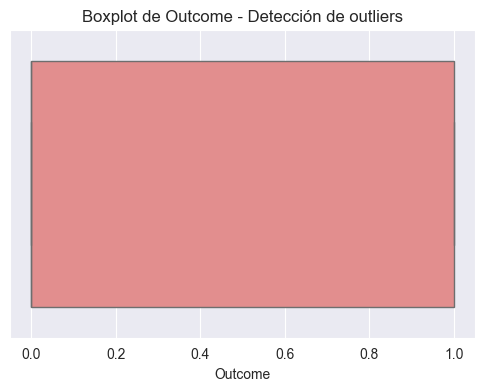

In [17]:
for col in numerical:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col], color='lightcoral')
    plt.title(f'Boxplot de {col} - Detección de outliers')
    plt.show()

In [19]:
for col in numerical:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers (valores fuera de [{lower_bound:.2f}, {upper_bound:.2f}])")


Pregnancies: 4 outliers (valores fuera de [-6.50, 13.50])
Glucose: 0 outliers (valores fuera de [36.00, 204.00])
BloodPressure: 14 outliers (valores fuera de [40.00, 104.00])
SkinThickness: 3 outliers (valores fuera de [1.00, 57.00])
Insulin: 24 outliers (valores fuera de [-94.38, 360.62])
BMI: 8 outliers (valores fuera de [13.85, 50.25])
DiabetesPedigreeFunction: 29 outliers (valores fuera de [-0.33, 1.20])
Age: 9 outliers (valores fuera de [-1.50, 66.50])
Outcome: 0 outliers (valores fuera de [-1.50, 2.50])


### Observacion:
- Segun los resultados obtenidos no eliminamos los outliers.
- Para preservar la integridad y riqueza del dataset.
- Aprovecharemos la capacidad inherente de los árboles para manejar valores extremos sin degradar la calidad predictiva.

In [20]:
df.groupby('Outcome')[numerical].mean()



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Outcome,,,,,,,,,
0,3.298000,110.643863,70.877339,27.235457,130.287879,30.859674,0.429734,31.190000,0.0
1,4.865672,142.319549,75.321429,33.000000,206.846154,35.406767,0.550500,37.067164,1.0


In [21]:
cols_with_invalid_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Reemplazar 0 por NaN en las columnas afectadas
df[cols_with_invalid_zeros] = df[cols_with_invalid_zeros].replace(0, np.nan)

# Ver cuántos valores faltantes tenemos ahora
df[cols_with_invalid_zeros].isnull().sum()


Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

In [22]:
df[cols_with_invalid_zeros] = df[cols_with_invalid_zeros].fillna(df[cols_with_invalid_zeros].median())


In [23]:
df.isnull().sum()


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## Escalado  de caracteristicas

In [24]:
# Variable objetivo
y = df['Outcome']

# Variables predictoras
X = df.drop('Outcome', axis=1)


In [ ]:
# Escalar variables numéricas (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_scaled

### Siguiente paso dividmos el Dataset en X e y

In [25]:
# División entrenamiento, test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=18,
                                                    stratify=y
)

### Modelamos el Arbol de decisiones y lo entrenamos

In [26]:
# Crear el modelo
model = DecisionTreeClassifier(random_state=18)

# Entrenar
model.fit(X_train, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,18
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [27]:
# Predecir sobre X_test
y_pred = model.predict(X_test)


In [28]:
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Matriz de confusión
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

# Reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))


Accuracy: 0.6818181818181818
Matriz de confusión:
[[76 24]
 [25 29]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.75      0.76      0.76       100
           1       0.55      0.54      0.54        54

    accuracy                           0.68       154
   macro avg       0.65      0.65      0.65       154
weighted avg       0.68      0.68      0.68       154



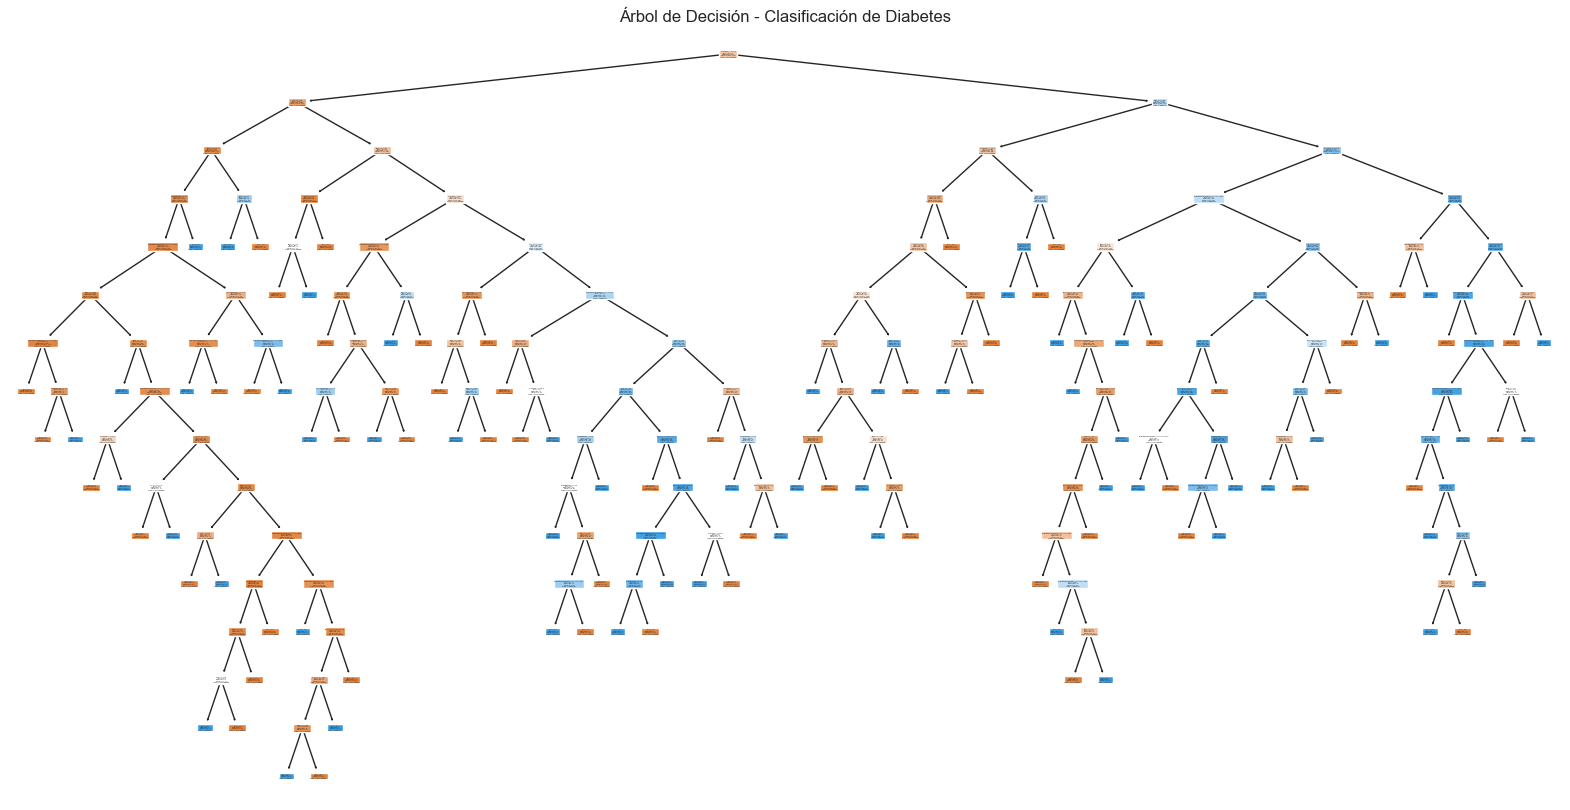

In [29]:
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X.columns, class_names=['No Diabetes', 'Diabetes'], filled=True)
plt.title("Árbol de Decisión - Clasificación de Diabetes")
plt.show()

### Vamos a optimizar el Arbol de decision

In [30]:
model = DecisionTreeClassifier(random_state=18)

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}


In [31]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)


In [32]:
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 160 candidates, totalling 800 fits


,estimator,DecisionTreeC...ndom_state=18)
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [33]:
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("Mejor accuracy en CV:", grid_search.best_score_)


Mejores parámetros encontrados: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Mejor accuracy en CV: 0.7703851792616287


In [34]:
best_clf = grid_search.best_estimator_
y_pred_best = best_clf.predict(X_test)

print("Accuracy en test:", accuracy_score(y_test, y_pred_best))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred_best))
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_best))


Accuracy en test: 0.6948051948051948
Matriz de confusión:
[[74 26]
 [21 33]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       100
           1       0.56      0.61      0.58        54

    accuracy                           0.69       154
   macro avg       0.67      0.68      0.67       154
weighted avg       0.70      0.69      0.70       154



In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(best_clf, feature_names=X.columns, class_names=['No Diabetes', 'Diabetes'], filled=True)
plt.title("Árbol de Decisión - Clasificación de Diabetes")
plt.show()

### Observaciones:
>- Accuracy en test: 0.695 (~69.5%): El modelo acierta aproximadamente el 69.5% de las veces al clasificar correctamente si una persona tiene o no diabetes.
>- No está mal, pero hay espacio para mejorar, especialmente en problemas médicos donde errores pueden ser costosos.
> -                 Matriz de confusión:
> -         Predicho No Diabetes	Predicho Diabetes
> -         Real No Diabetes (0)	74 (Verdaderos Negativos)	26 (Falsos Positivos)
> -         Real Diabetes (1)	21 (Falsos Negativos)	33 (Verdaderos Positivos)
> -  Resultado:
> - 74 personas sin diabetes fueron correctamente clasificadas (TN).
> - 26 personas sanas fueron clasificadas erróneamente como diabéticas (FP).
> - 33 personas con diabetes fueron correctamente identificadas (TP).
> - 21 personas con diabetes NO fueron detectadas (FN), lo que es preocupante desde un punto de vista clínico.
>
>                   Reporte de clasificación
> -         Clase	Precision	Recall	F1-score	Support
> -         No Diabetes (0)	0.78	0.74	0.76	100
> -         Diabetes (1)	0.56	0.61	0.58	54
> -         Accuracy			0.69	154
> - Resultado:
> - Precision (0.56) para diabetes: De todas las veces que el modelo predijo “diabetes”, solo el 56% realmente tenía diabetes. Hay bastantes falsos positivos.
> - Recall (0.61) para diabetes: El modelo detectó el 61% de todos los casos reales de diabetes; el 39% no fue detectado (falsos negativos).
> - F1-score (0.58) para diabetes: El equilibrio entre precisión y recall es moderado, indicando que el modelo tiene un rendimiento regular en identificar pacientes diabéticos.
>
### Conclusion:
> - La clase no diabetes tiene mejores métricas (precisión y recall) porque hay más ejemplos en el dataset y es más fácil para el modelo identificar pacientes sanos.
> - La clase diabetes es más difícil para el modelo, lo que es habitual en datasets desbalanceados o con características superpuestas.
> - Los falsos negativos (21 casos) son preocupantes, pues pacientes con diabetes no detectados pueden tener consecuencias graves si no reciben tratamiento.
> - El modelo funciona razonablemente bien para identificar personas sanas, pero su capacidad para detectar diabetes es limitada.
> - En un contexto médico, es preferible maximizar el recall (sensibilidad) para diabetes, incluso si eso implica más falsos positivos. Esto puede lograrse ajustando el umbral de decisión o usando técnicas de balanceo de clases.
> - Probamos modelos más complejos (Random Forest, XGBoost) para mejorar el desempeño en la clase minoritaria.

## Hacemos el Ramdom Forest con GridSearch

### Optimizamos de nuevo el Arbol con otro modelo mas robusto para obtener un mejor resultado

In [35]:

rf = RandomForestClassifier(random_state=42)


In [36]:
param_grid_rf = {
    'n_estimators': [100, 200],            # número de árboles
    'max_depth': [5, 10, None],            # profundidad máxima
    'min_samples_split': [2, 5, 10],       # min muestras para dividir nodo
    'min_samples_leaf': [1, 2, 4],         # min muestras en hoja
    'criterion': ['gini', 'entropy']
}


In [37]:

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)


In [38]:
grid_search_rf.fit(X_train, y_train)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [39]:
print("Mejores parámetros Random Forest:", grid_search_rf.best_params_)
print("Mejor score CV:", grid_search_rf.best_score_)

best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)


print("Accuracy en test:", accuracy_score(y_test, y_pred_rf))
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_rf))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred_rf))


Mejores parámetros Random Forest: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Mejor score CV: 0.8126882580301213
Accuracy en test: 0.7337662337662337
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       100
           1       0.63      0.57      0.60        54

    accuracy                           0.73       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154

Matriz de confusión:
[[82 18]
 [23 31]]


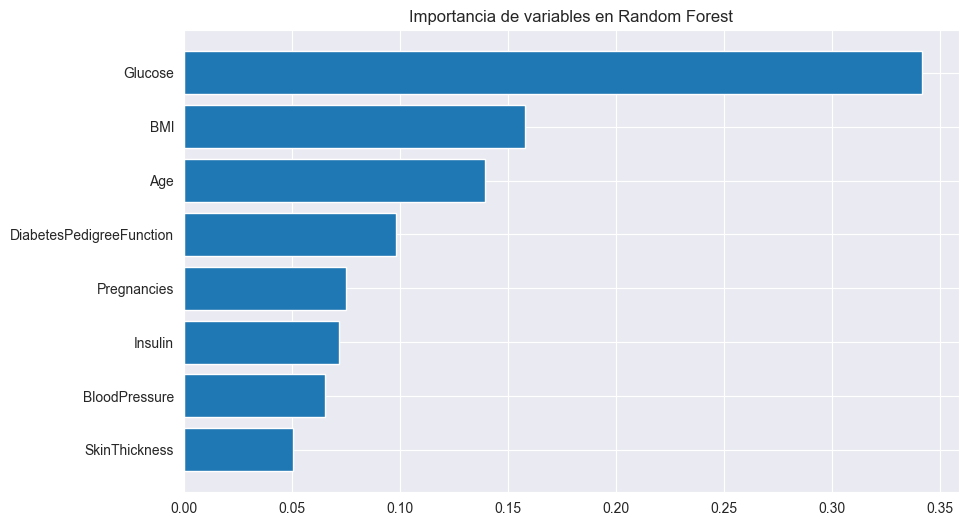

In [40]:

importances = best_rf.feature_importances_
features = X.columns

df_importances = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(df_importances['Feature'], df_importances['Importance'])
plt.gca().invert_yaxis()
plt.title("Importancia de variables en Random Forest")
plt.show()


In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(
    best_rf.estimators_[0],  # <- Primer árbol del bosque
    feature_names=X.columns,
    class_names=['No Diabetes', 'Diabetes'],
    filled=True
)
plt.title("Árbol de Decisión dentro del Random Forest")
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

for i in range(3):
    plot_tree(
        best_rf.estimators_[i],
        feature_names=X.columns,
        class_names=['No Diabetes', 'Diabetes'],
        filled=True,
        ax=axes[i]
    )
    axes[i].set_title(f"Árbol {i+1} del Random Forest")

plt.tight_layout()
plt.show()

### Observaciones:
> - Mejores parámetros:
> - criterion: gini — Usa índice Gini para medir la calidad de la división.
> - max_depth: None — Los árboles no tienen límite de profundidad (pueden crecer hasta que no se pueda dividir más).
> - min_samples_leaf: 4 — Cada hoja debe tener al menos 4 muestras, lo que ayuda a evitar sobreajuste.
> - min_samples_split: 2 — El mínimo para dividir un nodo es 2 muestras.
> - n_estimators: 100 — Se usaron 100 árboles en el bosque.
>
> - Mejor score CV (validación cruzada): 81.3%
> - Indica un buen desempeño promedio en las distintas particiones del entrenamiento, mostrando que el modelo generaliza razonablemente bien.
>
> - Accuracy en test: 73.4%: El modelo clasifica correctamente alrededor del 73% de las muestras en el conjunto de prueba.
>
>           Reporte de clasificación por clase
>       Clase	Precisión	Recall	F1-score	Soporte
>       No Diabetes (0)	0.78	0.82	0.80	100
>       Diabetes (1)	0.63	0.57	0.60	54
>
> - No diabetes (0): El modelo tiene alta precisión (78%) y buen recall (82%), detectando bien a los sanos.
> - Diabetes (1):La precisión baja a 63% y el recall a 57%, es decir, de todos los casos que el modelo predice como diabéticos, el 63% realmente lo son; y detecta solo el 57% de los diabéticos reales (falsos negativos importantes).
> - El F1-score para diabetes es 0.60, mostrando que hay margen para mejorar.
>
>               Matriz de confusión
>       Predicho No Diabetes	Predicho Diabetes
>       Real No Diabetes (0)	82 (TN)	18 (FP)
>       Real Diabetes (1)	23 (FN)	31 (TP)
>
> - El modelo clasifica correctamente a 82 personas sanas y 31 diabéticos.
> - Sin embargo, hay 23 diabéticos que no detecta (falsos negativos), y 18 personas sanas clasificadas erróneamente como diabéticas (falsos positivos).
>
### Conclusion:
> - La mejora en accuracy y precision respecto al árbol simple es clara.
> - Sin embargo, el recall para la clase diabetes sigue siendo limitado: detecta poco más de la mitad de los pacientes con diabetes reales.
> - En un contexto médico, los falsos negativos son críticos porque significan pacientes enfermos que podrían no recibir tratamiento.
> -

In [43]:
# Guardamos todos los archivos
X_train.to_csv(r'C:\Users\Alia\Documents\GitHub\Arbol de decisiones\aliasys-arbol-de-decision\data\processed/X_train.csv', index=False)
X_test.to_csv(r'C:\Users\Alia\Documents\GitHub\Arbol de decisiones\aliasys-arbol-de-decision\data\processed/X_test.csv', index=False)
y_train.to_csv(r'C:\Users\Alia\Documents\GitHub\Arbol de decisiones\aliasys-arbol-de-decision\data\processed/y_train.csv', index=False)
y_test.to_csv(r'C:\Users\Alia\Documents\GitHub\Arbol de decisiones\aliasys-arbol-de-decision\data\processed/y_test.csv', index=False)

# También puedes guardarlos en formato numpy si prefieres
np.save(r'C:\Users\Alia\Documents\GitHub\Arbol de decisiones\aliasys-arbol-de-decision\data\processed/X_train.npy', X_train.values)
np.save(r'C:\Users\Alia\Documents\GitHub\Arbol de decisiones\aliasys-arbol-de-decision\data\processed/X_test.npy', X_test.values)
np.save(r'C:\Users\Alia\Documents\GitHub\Arbol de decisiones\aliasys-arbol-de-decision\data\processed/y_train.npy', y_train.values)
np.save(r'C:\Users\Alia\Documents\GitHub\Arbol de decisiones\aliasys-arbol-de-decision\data\processed/y_test.npy', y_test.values)


Variables X, y y sus particiones guardadas en carpeta 'processed'.


In [45]:
# Guardar modelo Random Forest
joblib.dump(best_rf, r'C:\Users\Alia\Documents\GitHub\Arbol de decisiones\aliasys-arbol-de-decision\models\random_forest_model.pkl')

# Guardar DataFrame preprocesado
df.to_csv(r'C:\Users\Alia\Documents\GitHub\Arbol de decisiones\aliasys-arbol-de-decision\data\processed\diabetes_data_preprocessed.csv', index=False)

# Guardar predicciones
predicciones = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred_rf})
predicciones.to_csv(r'C:\Users\Alia\Documents\GitHub\Arbol de decisiones\aliasys-arbol-de-decision\models\predicciones_random_forest.csv', index=False)

# Guardar reporte de clasificación
reporte = classification_report(y_test, y_pred_rf)
with open(r'C:\Users\Alia\Documents\GitHub\Arbol de decisiones\aliasys-arbol-de-decision\models\reporte_clasificacion.txt', 'w') as f:
    f.write(reporte)


Archivos guardados en la carpeta 'processed'.
